Notes:
 * same as rev_tuned, but with the old revised configuration

In [5]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/revised_35_run_1'
data_files = '/mnt/tess/astronet/tfrecords-35-val/*'
tces_file = '/mnt/tess/astronet/tces-v12-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/revised_35_run_1/1/AstroCNNModel_revised_20220220_150526',
 '/mnt/tess/astronet/checkpoints/revised_35_run_1/2/AstroCNNModel_revised_20220220_151226',
 '/mnt/tess/astronet/checkpoints/revised_35_run_1/3/AstroCNNModel_revised_20220220_151926',
 '/mnt/tess/astronet/checkpoints/revised_35_run_1/4/AstroCNNModel_revised_20220220_152639',
 '/mnt/tess/astronet/checkpoints/revised_35_run_1/5/AstroCNNModel_revised_20220220_153351',
 '/mnt/tess/astronet/checkpoints/revised_35_run_1/6/AstroCNNModel_revised_20220220_154105',
 '/mnt/tess/astronet/checkpoints/revised_35_run_1/7/AstroCNNModel_revised_20220220_154816',
 '/mnt/tess/astronet/checkpoints/revised_35_run_1/8/AstroCNNModel_revised_20220220_155527',
 '/mnt/tess/astronet/checkpoints/revised_35_run_1/9/AstroCNNModel_revised_20220220_160235',
 '/mnt/tess/astronet/checkpoints/revised_35_run_1/10/AstroCNNModel_revised_20220220_160951']

In [6]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
2461 records
Running model 2
2461 records
Running model 3
2461 records
Running model 4
2461 records
Running model 5
2461 records
Running model 6
2461 records
Running model 7
2461 records
Running model 8
2461 records
Running model 9
2461 records
Running model 10
2461 records


In [7]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.2

In [8]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [9]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [10]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [11]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 1.0
Precision: 0.10564811052417716


In [12]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

In [13]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

267924099
268058755
270613669
274061306
274129865
274764311
274913960
275530995
275658545
276165770
277414027
277854181
282460772
298073824
298557393
331189568
331578319
344453376
351193224
351200720
356776209
367169035
380724118
387366495
40612890
416282321
416282724
426350650
42832478
429259165
430316024
430322052
43306175
43564749
436083994
452724091
64418963
66365216
1001239799
100525825
10657946
128340531
128503477
128627433
129488643
136651206
138078677
154214348
154656705
162333784
164266012
167464295
1883869938
188837285
190687149
194138888
1979259478
199164436
199600304
199878093
2003757386
202442062
233839656
239639659
240573056
24860612
259770512
260976846
265150409
266794067
267486819
267662701
276705323
27689264
276921056
277170271
277420659
277848886
27804376
278555119
278910035
27962331
295206687
295305511
298972209
304969065
305308009
305873892
312821931
314461389
329710448
330131047
330470939
346340708
352156967
352271354
357302392
364567324
364968470
365411940
3694849

261563358
261744725
262574104
262576518
262576636
262614797
262721753
262866776
263012764
265332741
265467432
267194398
267363765
269378599
269849513
269898810
270247428
270275278
270276558
270312035
270312112
270342707
270505202
270558473
271639087
271723952
271725220
271795775
271810226
271810257
271971704
271999852
272087003
272188971
272238399
272434319
272472265
272473053
272564718
273395661
273654759
273654781
273790685
276568546
276738707
276783657
276845678
276963913
276965481
277045346
277099881
277147766
277891592
277941517
277978007
278002790
278022845
278139052
278267286
278287749
278385856
278409392
278413697
278544653
278589939
278632192
278684936
278724765
278777070
278822780
278897282
278898478
278990892
278991552
279051289
279245231
279322995
279324400
279355764
279431010
279475851
280050415
280052157
280910319
281578420
281924463
281976620
282272775
287532056
287588629
287591034
287640232
287721776
287722370
287870438
287873287
287874075
290268464
290289095
290289792


In [14]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 340066802)

,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,


In [15]:
pl[pl.index == 340066802]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,,,,,,,


### PR curve

In [16]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_e']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [17]:
num_cond_pos = int(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.11932331611842084, max R: 1.0, max P: 0.3333333333333333
100% recall at: 10%, threshold: 0.5050000000000545


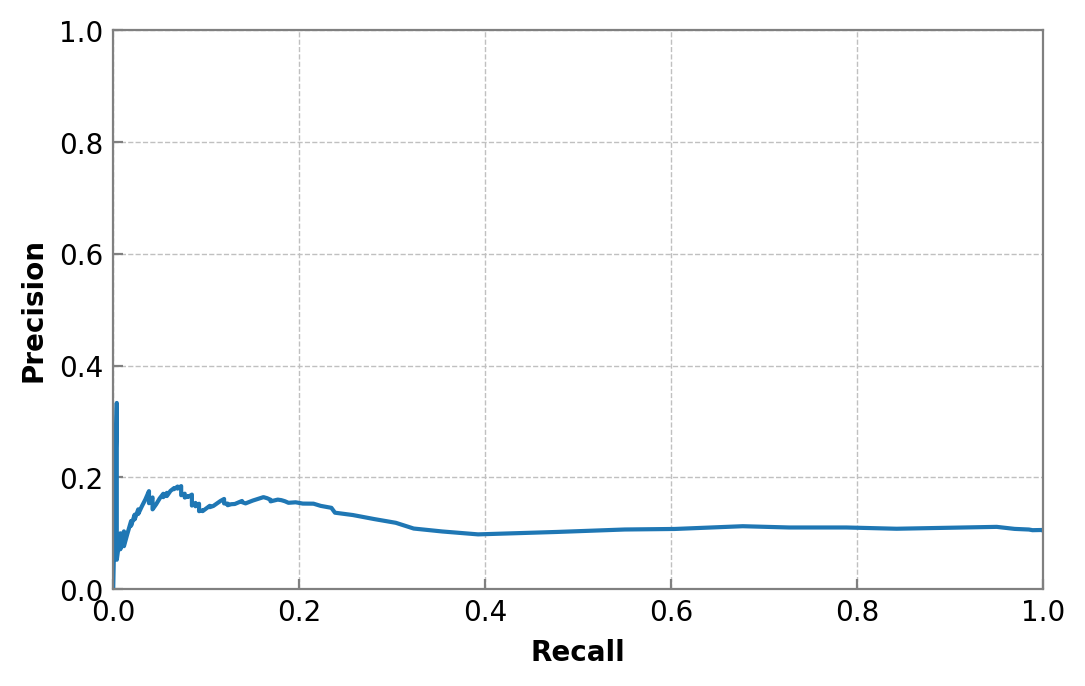

In [18]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    ps.append(p)
    rs.append(r)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)